# Data Simulation with `msprime`

This notebook introduces the `msprime` simulator, a high‑performance library for generating ancestry and mutation data under the coalescent. It supports separate ancestry and mutation simulation via the succinct tree sequence data structure. 

`msprime` is widely used in population genetics because it can simulate whole chromosomes efficiently and stores results compactly using `tskit`.

## Simulating a constant population

In this section, we simulate a **single, constant-size diploid population**. 

Key parameters are the sequence length (bp), effective population size `Ne`, mutation rate, recombination rate, and the number of sampled diploid individuals. 

Changing these values shifts coalescent times, recombination breakpoints, and the number of segregating sites you observe.


In [73]:
import msprime
import numpy as np
import matplotlib.pyplot as plt

Set the parameters for this constant-population example. 

The block below shows a working configuration you can run immediately: edit the numbers (or uncomment the placeholders) to try your own scenarios. 

In [74]:
# Parameters for a constant-size diploid population (edit to explore)
sequence_length = 50000  # bp
ne = 100  # effective population size
mutation_rate = 1e-7
recombination_rate = 1e-8
samples = 10  # number of diploid individuals

# Alternatively, uncomment and set your own values
# sequence_length = ...
# ne = ...
# mutation_rate = ...
# recombination_rate = ...
# samples = ...


We build an `msprime.Demography` object to store populations and demographic events. Here we just add one population with a fixed `Ne`, but you can extend it with growth, splits, or migration.


In [35]:
demography = msprime.Demography()
demography.add_population(initial_size=ne)

# Simulate ancestry and mutations
ts_anc = msprime.sim_ancestry(samples=samples,
                            recombination_rate=recombination_rate,
                            sequence_length=sequence_length,
                            demography=demography)

ts = msprime.sim_mutations(ts_anc, rate=mutation_rate)
# msprime simulates the ancestry and mutations separately

print('Tree sequence has', ts.num_sites, 'segregating sites and', ts.num_trees, 'trees.')

Tree sequence has 6 segregating sites and 3 trees.


Plot the trees as **Scalable Vector Graphics (SVG)** before and after mutations are added to the branches.


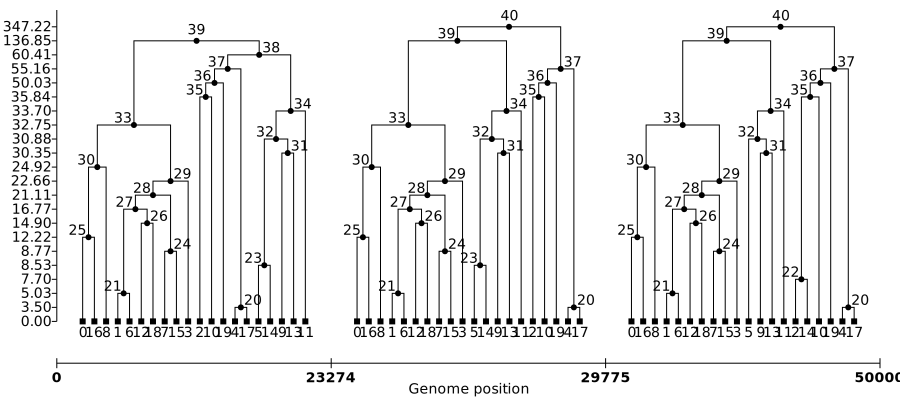

In [41]:
from IPython.display import display
svg_size = (900, 400)
svg_string = ts_anc.draw_svg(
    size=svg_size,
    y_axis=True, y_label=" ",  # optional: show a time scale on the left
    time_scale="rank", x_scale="treewise",  # Force same axis settings as the text view
)
display(svg_string)

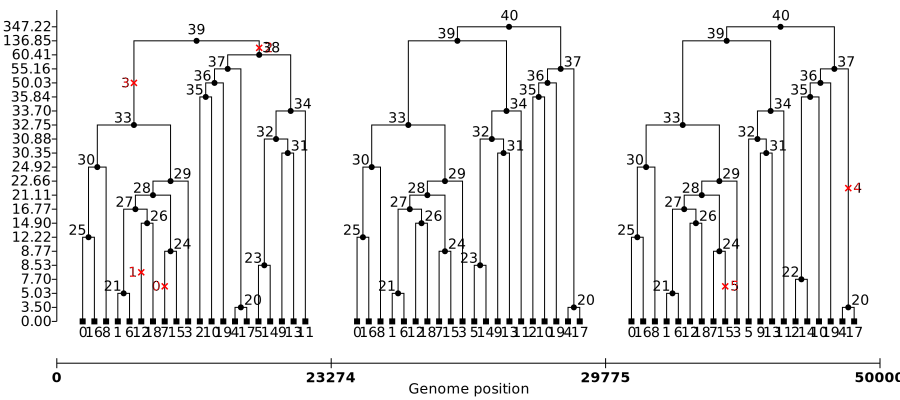

In [42]:
svg_size = (900, 400)
svg_string = ts.draw_svg(
    size=svg_size,
    y_axis=True, y_label=" ",  # optional: show a time scale on the left
    time_scale="rank", x_scale="treewise",  # Force same axis settings as the text view
)
display(svg_string)

The simulation generates a tree sequence `ts`, which is essentially a record of how all sampled individuals coalesce back to their common ancestors. 

By placing mutations along the branches of these ancestral trees (according to the specified mutation rate), `msprime` outputs simulated genetic variation—ultimately yielding SNP data or variant matrices that can be used for downstream analyses, such as training neural posterior estimators in our pipeline. 

### Let us check the SNP matrix from the tree sequence.

> A quick reminder: the SNP matrix can be seen as the simulated data x, and the parameters used for simulation are the $\theta$.

In [56]:
genotypes = ts.genotype_matrix()  # Shape: (n_variants, n_samples)
print('Genotype matrix shape:', genotypes.shape)

Genotype matrix shape: (1863, 20)


This is **one type of data** we can use as the input for our parameter inference later. 

To feed an neural posterior estimator, we need lower-dimensional features. These can be predefined **summary statistics** based on the SNP matrix or features extracted by a neural embedding network (pretrained or learned jointly). 

In this workshop, we will stick with using predefined **summary statistics**.


## Summary statistics: allele frequency spectrum (AFS)
AFS counts how many mutations appear in exactly k haploids. We can use the `tskit` package to extract the AFS directly.

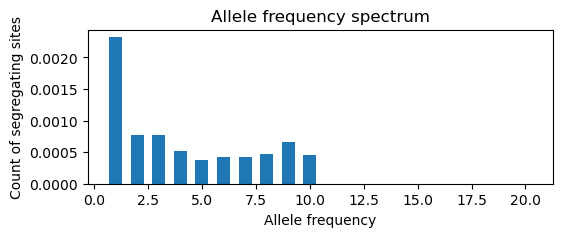

In [91]:
# Compute and plot the folded AFS
afs = ts.allele_frequency_spectrum()
freqs = np.arange(1, len(afs))

plt.figure(figsize=(6, 2))
plt.bar(freqs, afs[1:], width=0.6)
plt.xlabel('Allele frequency')
plt.ylabel('Count of segregating sites')
plt.title('Allele frequency spectrum')
plt.show()


With AFS, we now have a pair of theta and x (the population parameters, and AFS from its SNP matrix) for NPE.

> AFS reflects the evolutionary history of the population. Larger populations (higher `Ne`) tend to have deeper coalescent trees with more rare variants, while smaller populations coalesce quickly and show fewer segregating sites. Toggle tree visualisation in the next cell to connect the trees to the spectrum.


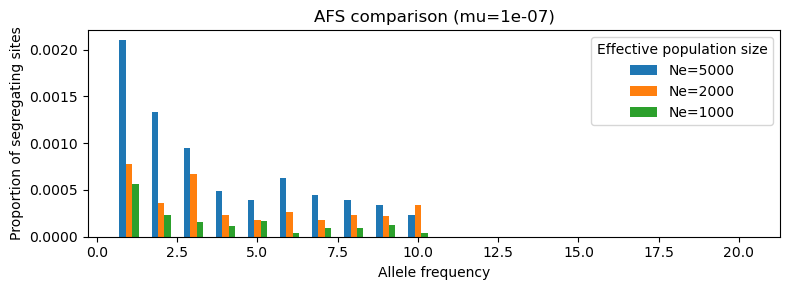

In [112]:
ne_values = [5000, 2000, 1000]  # try other values to see how the spectrum shifts

plt.figure(figsize=(8, 3))
for idx, ne_val in enumerate(ne_values):
    demography = msprime.Demography()
    demography.add_population(initial_size=ne_val)

    ts_anc = msprime.sim_ancestry(samples=samples,
                                recombination_rate=recombination_rate,
                                sequence_length=sequence_length,
                                demography=demography)

    ts = msprime.sim_mutations(ts_anc, rate=mutation_rate)
    afs = ts.allele_frequency_spectrum()
    freqs = np.arange(1, len(afs))

    bar_width = 0.6 / len(ne_values)
    offset = (idx - (len(ne_values)-1)/2) * bar_width
    plt.bar(freqs + offset, afs[1:], width=bar_width, label=f'Ne={ne_val}')

plt.xlabel('Allele frequency')
plt.ylabel('Proportion of segregating sites')
plt.title(f'AFS comparison (mu={mutation_rate})')
plt.legend(title='Effective population size')
plt.tight_layout()
plt.show()


AFS is tightly linked to population parameters: 
- Larger `Ne` lengthens the branches along the tree, increases the number of rare variants. 
- Higher mutation rates (`μ`) raise the total count of segregating sites. 
- Recombination rate (`r`) reshapes genealogies by creating more independent segments, which flattens linkage and can smooth the spectrum. 

In practice, we use the AFS (our summary statistic `x`) together with the simulator parameters `θ = (Ne, μ, r, ...)` to train a neural posterior estimator. Once trained, the NPE maps an observed AFS to a posterior over the hidden parameters, letting us infer the demography from real genetic data.